## Initialize the environment

In [1]:
from PyDakota.regression import *
from PyDakota.models.genz import GenzFunction
from PyDakota.approximation import *
from PyDakota.math_tools import compute_hyperbolic_indices
import multiprocessing
import time
from scipy.misc import comb
from functools import partial
import numpy

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.usetex'] = True # use latex for all text handling
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{siunitx}', r'\usepackage{amsmath}',r'\usepackage{amssymb}']

# to just create static png plots use 
%matplotlib inline

numpy.random.seed(3)

## Define function we want to approximate
We will use the oscillstory frunction from the Genz integration test suite.
$$f(x)=cos\left(2\pi w_1+\sum_{i=1}^d c_i x_i\right),\quad x\in[0,1]^d$$
where we set $$w_1=0, \quad c_i=\frac{i-0.5}{d}K, \quad K=C\sum_{i=1}^d c_i, \quad C=10$$

In [2]:
num_vars = 2
variables = BoundedVariables()
ranges = define_homogeneous_ranges(num_vars, 0., 1.);
variables.set_ranges(ranges)

function = GenzFunction('oscillatory',num_vars)
function.set_coefficients(10., 'no-decay')

## Initialize the approximation
Dakota supports many approximation methods. Here we focus on how to build a total-degree multivariate polynomial approximation

$$f(x)\approx p(T(x))=p(u)=\sum_{\|\lambda\|_1\le 10} c_\lambda\phi_\lambda(u).$$ 

To define a 3rd order total degree monomial approximation run

In [3]:
var_transform = AffineVariableTransformation()
var_transform.set_variables(variables)

degree = 20
approx = Monomial()
approx.set_variable_transformation(var_transform)
basis_indices = compute_hyperbolic_indices(num_vars, degree, 1.)
approx.set_basis_indices(basis_indices)

## Set up the cross validation

In [4]:
num_training_samples = 100#2*basis_indices.shape[1]
training_samples = numpy.random.uniform(0,1,(num_vars,num_training_samples))
function_opts = {'eval_type':'value-grad'}
training_function_vals = function.value(training_samples,function_opts)
basis_matrix = approx.generate_basis_matrix(training_samples)

num_folds = 10; seed=-1# deterministic partition
#regression_type = LEAST_ANGLE_REGRESSION
regression_type = LASSO_REGRESSION
#regression_type = ORTHOG_MATCH_PURSUIT
cv_opts = {'num-points':num_training_samples,'num-folds':num_folds,'seed':seed}
regression_opts = {'verbosity':0,'cv-opts':cv_opts,'store-history':True}
# setting store_history to False causes cv_solver to terminate early when generating best solution
# there is some numerical drift I need to find the cause of.
cv_solver = CrossValidatedSolver()
cv_solver.set_linear_system_solver(regression_type)
print numpy.linalg.norm(basis_matrix), numpy.linalg.norm(training_function_vals)
cv_solver.solve(basis_matrix, training_function_vals, regression_opts)
scores = cv_solver.get_best_scores()
cv_iterator = cv_solver.get_cross_validation_iterator()
cv_iterator = cast_to_linear_system_cross_validation_iterator(cv_iterator)
cv_scores = cv_iterator.get_scores()
cv_residuals = cv_iterator.get_unique_tolerances()
best_tolerances = cv_iterator.get_adjusted_best_residual_tolerances()[:,0]
cv_solutions = cv_solver.get_final_solutions()
print "Cross validation error:",scores
print "Best tolerances:",best_tolerances
print "Exit tolerance values:",cv_solver.get_final_residuals()

num_rhs = training_function_vals.shape[1]
num_validation_samples = 100
validation_samples = numpy.random.uniform(0,1,(num_vars,num_validation_samples))
validation_function_vals = function.value(validation_samples, function_opts)
regression_opts = {'regression_type':regression_type}
solver = regression_solver_factory(regression_opts) 
solver.solve(basis_matrix, training_function_vals, regression_opts)
mse = []
residuals = []
for i in range(num_rhs):
    coef = solver.get_solutions_for_all_regularization_params(i)
    num_steps = coef.shape[1]
    approx.set_coefficients(coef)
    approx_validation_vals = approx.value(validation_samples)
    approx_training_vals = approx.value(training_samples)
    residuals.append(numpy.linalg.norm(numpy.tile(training_function_vals[:,i],(num_steps,1)).T-approx_training_vals,axis=0))
    assert numpy.allclose(solver.get_residuals_for_all_regularization_params(i),residuals[i])
    #print cv_solver.get_residuals_for_all_regularization_params(i)
    mse.append(1./num_validation_samples*numpy.linalg.norm(numpy.tile(validation_function_vals[:,i],(num_steps,1)).T-approx_validation_vals,axis=0)**2)


approx.set_coefficients(cv_solutions)
cv_approx_validation_vals = approx.value(validation_samples)
cv_approx_training_vals = approx.value(training_samples)
cv_solution_residuals = numpy.linalg.norm(training_function_vals-cv_approx_training_vals,axis=0)
assert numpy.allclose(cv_solver.get_final_residuals(), cv_solution_residuals)
cv_approx_mse = 1./num_validation_samples*numpy.linalg.norm(validation_function_vals-cv_approx_validation_vals,axis=0)**2
print mse[-1].shape, coef.shape, training_samples.shape, basis_indices.shape, residuals[-1].shape

20.7245094728 56.3710530742
Cross validation error: [  7.51587930e-07   1.57022738e-05   1.41461395e-04]
Best tolerances: [  1.12847953e-05   1.71656981e-04   5.16879816e-04]
Exit tolerance values: [  1.12396163e-05   1.67944995e-04   5.16249798e-04]
(1000,) (231, 1000) (2, 100) (2, 231) (1000,)


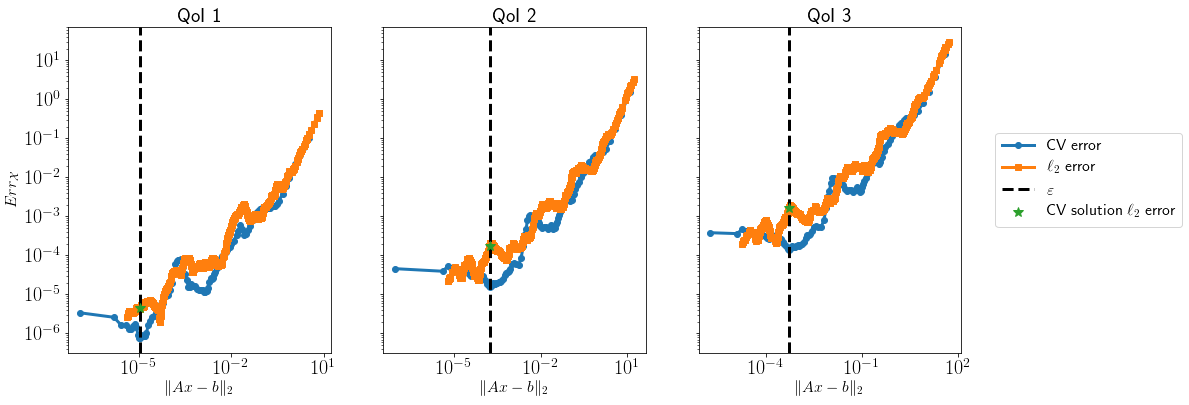

In [5]:
f,axs=plt.subplots(1,num_rhs,sharey=True,figsize=(16, 6))
axs = axs.ravel()
for i in range(num_rhs):
    axs[i].loglog(cv_residuals[i]/.9,cv_scores[i],'-o',label='CV error')
    axs[i].loglog(residuals[i],mse[i],'-s',label='$\ell_2$ error')
    axs[i].axvline(best_tolerances[i],linestyle='--',color='k',label='$\\varepsilon$')
    axs[i].loglog(cv_solution_residuals[i],cv_approx_mse[i],'*',ms=10,label='CV solution $\ell_2$ error')
    axs[i].set_title('QoI %d'%(i+1))
    axs[i].set_xlabel('$\lVert Ax-b \\rVert_2$')
axs[0].set_ylabel(r'$Err_\mathcal{X}$')
axs[-1].legend(fontsize=16,bbox_to_anchor=(1.1, .7))

## Using cross validation to choose polynomial degree

In [9]:
def cross_validated_solve(basis_matrix,regression_type, training_function_vals, regression_opts):
    cv_solver = CrossValidatedSolver()
    cv_solver.set_linear_system_solver(regression_type)
    cv_solver.solve(basis_matrix, training_function_vals, regression_opts)
    scores = cv_solver.get_best_scores()
    return scores

regression_opts = {'verbosity':0,'cv-opts':cv_opts,'store-history':True}
cv_solve = partial(cross_validated_solve,regression_type=regression_type,
                   training_function_vals=training_function_vals, regression_opts=regression_opts)
# Using max_eval_concurrency>1 is slower than using max_eval_concurrency=1
# I think this has something to do with OMP_NUM_THREADS used by NumPy
# if want to use
max_eval_concurrency=max(multiprocessing.cpu_count(),1)
# open tutorial with OMP_NUM_THREADS=1 jupyter notebook
# this is not well load balanced because higher-degrees much more expensive than lower degrees
# thus speed up will not be close to linear
t0 = time.time()
pool = multiprocessing.Pool(max_eval_concurrency)
args = []
poly_degrees=numpy.arange(2,degree)
for deg in poly_degrees:
    num_terms = int(numpy.round(comb(num_vars+deg, num_vars)))
    basis_matrix_view = basis_matrix[:,:num_terms]
    args.append(basis_matrix_view)
cv_score_per_degree = numpy.asarray(pool.map(cv_solve,args))
print 'that_took:', time.time()-t0

that_took: 4.30189919472


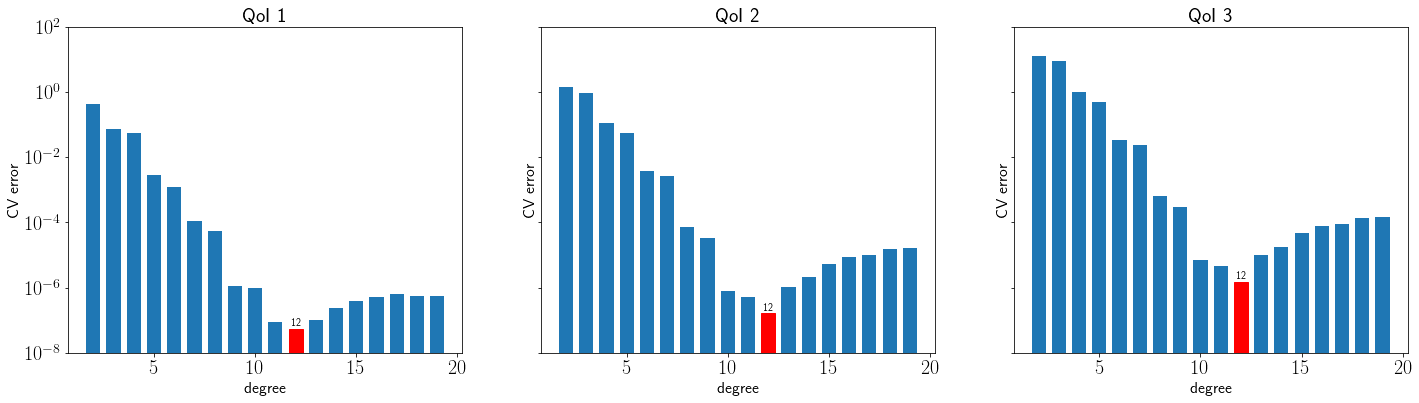

In [7]:
from PyDakota.visualization import cross_validated_degree_bar_plot
cross_validated_degree_bar_plot(cv_score_per_degree, poly_degrees)